<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/pi/test1/pi_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# exercise 1

import torch

v = torch.tensor([[1, 12], [-3, 5], [2, 0]])
alt_v = v[:, 1]
alt_v[1] = v[1, 0]
alt_v

tensor([12, -3,  0])

In [ ]:
# exercise 2
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

X = torch.rand(250).reshape(-1, 1)
e = torch.rand(250)/4
y = 2 * X + 3 + e

true_w = torch.tensor([2.0])
true_b = 3

torch.manual_seed(42)
np.random.seed(42)

net = nn.Sequential(nn.Linear(1, 1))

net[0].weight.data.fill_(1)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.05)

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((X, y), batch_size)

num_epochs=10
for epoch in range(num_epochs):
    for X_iter, y_iter in data_iter:
        l = loss(net(X_iter), y_iter)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(X), y)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 0.034666
Epoch 2, Loss 0.011724
Epoch 3, Loss 0.009746
Epoch 4, Loss 0.008418
Epoch 5, Loss 0.007443
Epoch 6, Loss 0.006770
Epoch 7, Loss 0.006292
Epoch 8, Loss 0.005950
Epoch 9, Loss 0.005710
Epoch 10, Loss 0.005543


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10, 250])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([250, 250])) that is different to the input size (torch.Size([250, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
print(net[0].weight.data)
print(true_w)
print(net[0].bias.data)
print(true_b)

tensor([[2.0684]])
tensor([2.])
tensor([3.0847])
3


In [ ]:
# exercise 4

import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('https://s3.amazonaws.com/text-datasets/nietzsche.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 9935
preface
indeed it stands at all for there are scoffers who maintain that it


In [ ]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['preface']
[]
[]
['supposing', 'that', 'truth', 'is', 'a', 'woman', 'what', 'then', 'is', 'there', 'not', 'ground']
['for', 'suspecting', 'that', 'all', 'philosophers', 'in', 'so', 'far', 'as', 'they', 'have', 'been']
['dogmatists', 'have', 'failed', 'to', 'understand', 'women', 'that', 'the', 'terrible']
['seriousness', 'and', 'clumsy', 'importunity', 'with', 'which', 'they', 'have', 'usually', 'paid']
['their', 'addresses', 'to', 'truth', 'have', 'been', 'unskilled', 'and', 'unseemly', 'methods', 'for']
['winning', 'a', 'woman', 'certainly', 'she', 'has', 'never', 'allowed', 'herself', 'to', 'be', 'won', 'and']
['at', 'present', 'every', 'kind', 'of', 'dogma', 'stands', 'with', 'sad', 'and', 'discouraged', 'mien', 'if']
['indeed', 'it', 'stands', 'at', 'all', 'for', 'there', 'are', 'scoffers', 'who', 'maintain', 'that', 'it']


In [ ]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('of', 2), ('and', 3), ('to', 4), ('in', 5), ('is', 6), ('a', 7), ('that', 8), ('it', 9)]


In [ ]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['preface']
indices: [3523]
words: ['indeed', 'it', 'stands', 'at', 'all', 'for', 'there', 'are', 'scoffers', 'who', 'maintain', 'that', 'it']
indices: [188, 9, 694, 27, 17, 11, 39, 20, 5133, 31, 1017, 8, 9]


In [ ]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(570394, 28)

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


In [ ]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

In [ ]:
def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In [ ]:
batch_size, num_steps = 64, 4
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [ ]:
num_hiddens = 64
lstm_layer = nn.LSTM(len(vocab), num_hiddens, 4)

state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 64, 64])

In [ ]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [ ]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

In [ ]:
def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('philosophy', 55, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('philosophy', 55, net, vocab, device))

    return perplexities

In [ ]:
vocab_size, num_hiddens, device = len(vocab), 64, try_gpu()
num_epochs, lr = 250, 2.5

num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)
perplexities = train(model, train_iter, vocab, lr, num_epochs, device) #5 min

philosophy the the the the the the the the the the the the the th
philosophy have the will to the will to the will to the will to t
philosophy has her sole the spon as the sor to sor to some us the
philosophy which the will to speare that the sporan the sthing th
philosophy has not so the truth the grould beluth as the enclise 
philosophy has not sose the struggle again untrite of value of th
philosophy has ne preserving all to maintain the spirit and the g
philosophy which ware of value of all the strangelog and women wi
philosophy has ne propist ene to instand comenis any with the sph
philosophy what in evrow have beessions specier pait wor the orth
philosophy what the will to truth had notwillen that the strogghi
philosophy which the sphince to speak are the heid before us whic
philosophy which may been surem that ithese every sole enoushongh
philosophy whieh the will to delve of the will to dely behie cati
philosophy which of the wariest of all the struggle again the mos
philosophy

In [1]:
# exercise 3

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [2]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.CIFAR100(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.CIFAR100(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [35000, 15000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [3]:
def evaluate_accuracy(net, data_iter, loss, device):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

In [58]:
def train_epoch(net, train_iter, loss, optimizer, device):
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    net.to(device)
    for X, y in train_iter:
        # Compute gradients and update parameters
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

In [59]:
def train(net, train_iter, val_iter, test_iter, num_epochs, lr, device):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('Training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer, device)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter, loss, device)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')
    test_loss, test_acc = evaluate_accuracy(net, test_iter, loss, device)
    print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

In [60]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [61]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1)
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [62]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [63]:
batch_size, lr, num_epochs = 512, 0.02, 10
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [72]:
class ConvolutionalBlock(nn.Module):
    def __init__(self):
        super().__init__()

        # Left branch
        self.left_conv = nn.Conv2d(3, 10, kernel_size=5, padding=2)
        self.left_tanh = nn.Tanh()

        # First right block layers
        self.right1_left_conv = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.right1_left_batchnorm = nn.BatchNorm2d(32)
        self.right1_left_tanh = nn.Tanh()

        self.right1_middle_conv = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.right1_middle_batchnorm = nn.BatchNorm2d(64)
        self.right1_middle_tanh = nn.Tanh()

        self.right1_right_conv = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.right1_right_batchnorm = nn.BatchNorm2d(64)
        self.right1_right_second_conv = nn.Conv2d(64, 32, kernel_size=1)
        self.right1_right_second_batchnorm = nn.BatchNorm2d(32)
        self.right1_right_second_tanh = nn.Tanh()

        # Second right block layers
        self.right2_left_conv = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.right2_left_batchnorm = nn.BatchNorm2d(32)
        self.right2_left_tanh = nn.Tanh()

        self.right2_middle_conv = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.right2_middle_batchnorm = nn.BatchNorm2d(64)
        self.right2_middle_tanh = nn.Tanh()

        self.right2_right_conv = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.right2_right_batchnorm = nn.BatchNorm2d(64)
        self.right2_right_second_conv = nn.Conv2d(64, 32, kernel_size=1)
        self.right2_right_second_batchnorm = nn.BatchNorm2d(32)
        self.right2_right_second_tanh = nn.Tanh()

    def right_block(self, input, block_num):
        if block_num == 1:
            # First right block
            left = self.right1_left_conv(input)
            left = self.right1_left_batchnorm(left)
            left = self.right1_left_tanh(left)

            middle = self.right1_middle_conv(input)
            middle = self.right1_middle_batchnorm(middle)
            middle = self.right1_middle_tanh(middle)

            right = self.right1_right_conv(input)
            right = self.right1_right_batchnorm(right)
            right = self.right1_right_second_conv(right)
            right = self.right1_right_second_batchnorm(right)
            right = self.right1_right_second_tanh(right)
        else:
            # Second right block
            left = self.right2_left_conv(input)
            left = self.right2_left_batchnorm(left)
            left = self.right2_left_tanh(left)

            middle = self.right2_middle_conv(input)
            middle = self.right2_middle_batchnorm(middle)
            middle = self.right2_middle_tanh(middle)

            right = self.right2_right_conv(input)
            right = self.right2_right_batchnorm(right)
            right = self.right2_right_second_conv(right)
            right = self.right2_right_second_batchnorm(right)
            right = self.right2_right_second_tanh(right)

        output = torch.cat((left, middle, right), 1)
        return output

    def forward(self, input):
        left_output = self.left_conv(input)
        left_output = self.left_tanh(left_output)

        right_output = self.right_block(input, 1)  # First right block
        right_output = self.right_block(right_output, 2)  # Second right block

        output = torch.cat((left_output, right_output), 1)
        return output

In [73]:
net = nn.Sequential(
    ConvolutionalBlock(),
    nn.Flatten(),
    nn.Linear(141312, 100)) # bla

# The output of the convblock is 512x141312

In [74]:
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, test_iter, num_epochs, lr, try_gpu()) #2 min

Training on cuda:0
Epoch 1, Train loss 8.66, Train accuracy 6.96, Validation loss 7.12, Validation accuracy 6.28
Epoch 2, Train loss 4.59, Train accuracy 15.19, Validation loss 5.46, Validation accuracy 8.54
Epoch 3, Train loss 3.58, Train accuracy 22.07, Validation loss 5.06, Validation accuracy 10.08
Epoch 4, Train loss 3.22, Train accuracy 26.95, Validation loss 4.51, Validation accuracy 13.84
Epoch 5, Train loss 2.85, Train accuracy 32.31, Validation loss 4.32, Validation accuracy 14.23
Epoch 6, Train loss 2.57, Train accuracy 37.53, Validation loss 4.30, Validation accuracy 15.62
Epoch 7, Train loss 2.33, Train accuracy 42.77, Validation loss 4.26, Validation accuracy 14.81
Epoch 8, Train loss 2.09, Train accuracy 48.17, Validation loss 4.40, Validation accuracy 14.65
Epoch 9, Train loss 1.88, Train accuracy 53.72, Validation loss 4.24, Validation accuracy 15.79
Epoch 10, Train loss 1.69, Train accuracy 58.54, Validation loss 4.11, Validation accuracy 17.57
Test loss 4.10, Test ac

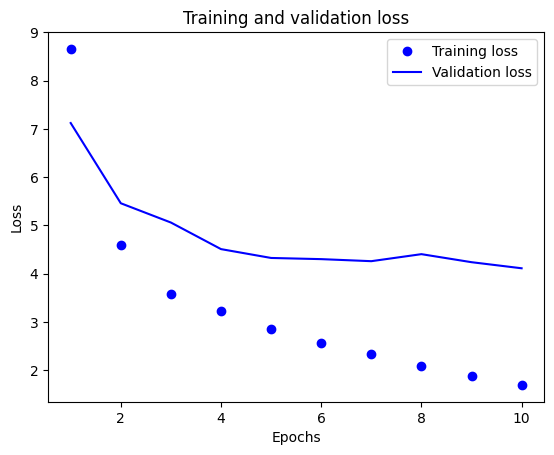

In [75]:
plot_loss(train_loss_all, val_loss_all)

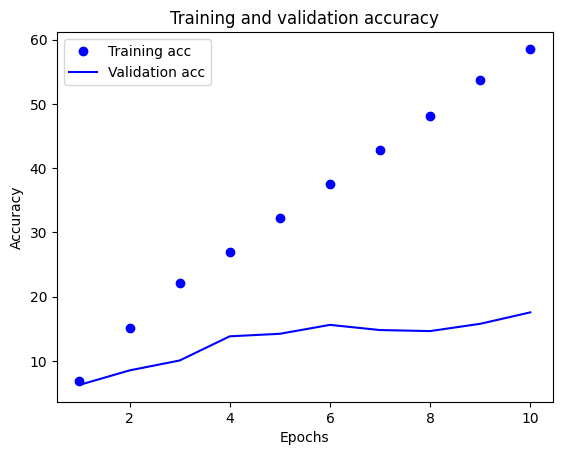

In [76]:
plot_accuracy(train_acc_all, val_acc_all)